In [2]:
!pip install controlnet-aux

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 282.4/282.4 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.0/510.0 kB 29.5 MB/s eta 0:00:00
  Attempting uninstall: timm
    Found existing installation: timm 1.0.11
    Uninstalling timm-1.0.11:
      Successfully uninstalled timm-1.0.11


In [4]:
import torch
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
from diffusers.utils import load_image
from PIL import Image
import cv2
import numpy as np


# 1. 윤곽선 검출(Canny) 이미지 생성
def generate_canny_image(image_path, low_threshold=100, high_threshold=200, target_size=(512, 512)):
    image = load_image(image_path).convert("L")  # Grayscale 변환
    image = np.array(image.resize(target_size))  # 크기 조정
    edges = cv2.Canny(image, low_threshold, high_threshold)  # Canny Edge Detection
    edges = Image.fromarray(edges).convert("RGB")  # PIL 이미지로 변환
    return edges


# 2. 인체 자세 검출(OpenPose) 이미지 생성
def generate_openpose_image(image_path, target_size=(512, 512)):
    from controlnet_aux import OpenposeDetector  # OpenPose 모델 로드
    openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")
    image = load_image(image_path).resize(target_size)  # 크기 조정
    openpose_image = openpose(image)
    openpose_image = openpose_image.resize(target_size)  # ControlNet과 동일 크기
    return openpose_image


# 3. Stable Diffusion ControlNet 파이프라인 설정
def generate_image_with_controlnets(canny_image, openpose_image, prompt, negative_prompt, generator_seed):
    # ControlNet 모델 로드
    edge_detection_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
    openpose_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16)

    # Stable Diffusion 파이프라인 설정
    pipe = StableDiffusionControlNetPipeline.from_pretrained(
        "runwayml/stable-diffusion-v1-5",
        controlnet=[edge_detection_controlnet, openpose_controlnet],
        torch_dtype=torch.float16
    )
    pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
    pipe = pipe.to("cuda")

    # 메모리 최적화
    pipe.enable_attention_slicing()
    pipe.enable_sequential_cpu_offload()

    # 프롬프트 및 시드 설정
    generator = torch.Generator(device="cuda").manual_seed(generator_seed)
    images = [openpose_image, canny_image]

    # 이미지 생성
    try:
        output_image = pipe(
            prompt=prompt,
            negative_prompt=negative_prompt,
            image=images,
            generator=generator,
            num_inference_steps=50,
            guidance_scale=7.5
        ).images[0]
    except RuntimeError as e:
        print(f"RuntimeError during image generation: {e}")
        raise

    return output_image


# 4. 실행 코드
if __name__ == "__main__":
    try:
        # 입력 이미지 경로
        input_image_path = "gsp_punch.jpg"

        # 1. 윤곽선 검출 이미지 생성
        canny_image = generate_canny_image(input_image_path, low_threshold=50, high_threshold=150)

        # 2. 인체 자세 검출 이미지 생성
        openpose_image = generate_openpose_image(input_image_path)

        # 3. 프롬프트 설정
        prompt = "A futuristic city skyline with people in artistic poses, cinematic lighting"
        negative_prompt = "low quality, blurry, overexposed"

        # 4. 이미지 생성
        result_image = generate_image_with_controlnets(
            canny_image=canny_image,
            openpose_image=openpose_image,
            prompt=prompt,
            negative_prompt=negative_prompt,
            generator_seed=42
        )

        # 5. 결과 저장 및 출력
        result_image.save("multi_controlnet_output.png")
        result_image.show()

    except Exception as e:
        print(f"Error: {e}")


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

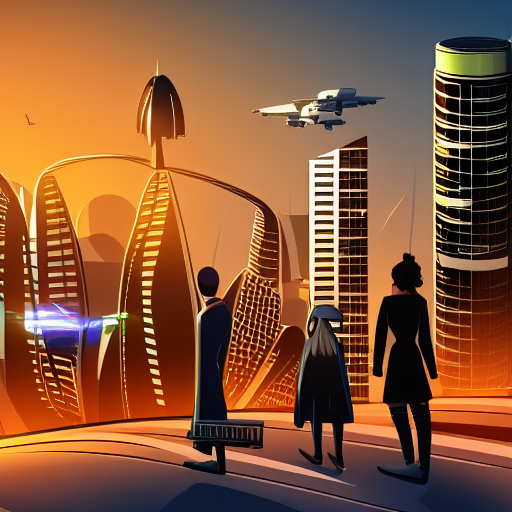

In [5]:
result_image